# Séries temporelles : prévisions de la pluie à J+3 et J+7

## Récupération des librairies

In [1]:
# récupération des librairies
%matplotlib inline

import numpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

## Récupération du jeu de données et affichage d'une série temporelle

In [2]:
# récupération du jeu de données
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [3]:
# conversion de la variable 'Date' au format datetime
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
# définition de l'index par la date
df.set_index(['Date'] , inplace=True)

In [5]:
# affichage de l'index
print(df.index)

DatetimeIndex(['2008-12-01', '2008-12-02', '2008-12-03', '2008-12-04',
               '2008-12-05', '2008-12-06', '2008-12-07', '2008-12-08',
               '2008-12-09', '2008-12-10',
               ...
               '2017-06-16', '2017-06-17', '2017-06-18', '2017-06-19',
               '2017-06-20', '2017-06-21', '2017-06-22', '2017-06-23',
               '2017-06-24', '2017-06-25'],
              dtype='datetime64[ns]', name='Date', length=145460, freq=None)


- Le jeu de données contient des observations pour la période du 1er Décembre 2008 au 25 Juin 2017.

In [6]:
# sélection des données pour une ville particulière
df_city = df[df["Location"] == "Cairns"]

In [7]:
# isolement des données de précipitation (rappel: RainTomorrow=1 si la pluie pour ce jour était de 1mm ou plus)
df_rain = df_city['Rainfall']

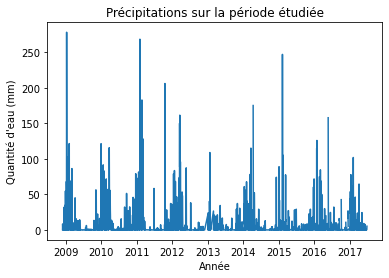

In [8]:
# affichage de la série temporelle
plt.plot(df_rain)
plt.xlabel("Année")
plt.ylabel("Quantité d'eau (mm)")
plt.title("Précipitations sur la période étudiée");

Les 7 derniers jours de l'ensemble de données à partir de Juin 2017 sont retenus comme ensemble de données de test et ces pas de temps seront traités comme hors échantillon.

In [9]:
# séparation de la série en deux parties: données d'entraînement et de test
split_point = len(df_rain) - 7
train, test = df_rain[0:split_point], df_rain[split_point:]

print("Taille des données d'entraînement: %d \n Taille des données de test: %d" % (len(train), len(test)))

Taille des données d'entraînement: 3033 
 Taille des données de test: 7


In [10]:
# création des fichiers de données
train.to_csv('rainfall_train.csv', index=False)
test.to_csv('rainfall_test.csv', index=False)

- La dernière observation dans le fichier "rainfall_train.csv" est le 18 Juin 2017. 
- Cela signifie que le 19 Juin 2017 et au-delà sont des pas de temps hors échantillon pour un modèle formé sur "rainfall_train.csv".

## Définition d'un modèle ARIMA simple

Les données ont une forte composante saisonnière annuelle (cf. "pyAusRainfall_Time_series"). Nous pouvons rendre les données stationnaires en prenant la différence saisonnière. Autrement dit, nous pouvons prendre l'observation d'un jour et soustraire l'observation du même jour il y a un an. Cela se traduira par un ensemble de données stationnaire à partir duquel nous pourrons ajuster un modèle ARIMA simple.

In [11]:
# fonction de différentiation saisonnière
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)

Cette opération peut s'inverser en ajoutant la valeur de l'observation il y a un an. Nous devrons le faire pour toutes les prévisions faites par un modèle formé sur les données désaisonnalisées.

In [12]:
# fonction d'inversion de la différentiation saisonnière
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [13]:
# chargement des données d'entraînement
series_train = pd.read_csv('rainfall_train.csv', header=0)

In [14]:
# chargement des données de test
series_test = pd.read_csv('rainfall_test.csv', header=0)

In [15]:
series_test

,Rainfall
0,0.0
1,0.0
2,0.4
3,0.2
4,1.0
5,1.2
6,5.2


In [16]:
# application de la différence saisonnière
X = series_train.values
days_in_year = 365
differenced = difference(X, days_in_year)

In [17]:
# ajustement du modèle ARIMA
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit()

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2668
Model:                 ARIMA(7, 0, 1)   Log Likelihood              -11929.344
Date:                Wed, 28 Sep 2022   AIC                          23878.688
Time:                        16:59:02   BIC                          23937.579
Sample:                             0   HQIC                         23899.998
                               - 2668                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2436      0.795     -0.306      0.759      -1.802       1.315
ar.L1         -0.0809      0.653     -0.124      0.901      -1.362       1.200
ar.L2          0.1562      0.214      0.731      0.4

## Prévision hors échantillon en une étape: J+1

Les modèles ARIMA sont parfaits pour les prévisions en une étape.

Une prévision en une étape est une prévision de l'étape de temps suivante dans la séquence à partir des données disponibles utilisées pour ajuster le modèle.

Dans ce cas, nous sommes intéressés par une prévision en une étape du jour du 19 Juin 2017.

### Utilisation de la fonction forecast()

Par défaut, la fonction forecast() d'un modèle ARIMA effectue une prévision hors échantillon en une seule étape. Le résultat de la fonction forecast() est un tableau contenant la valeur de la prévision, l'erreur standard de la prévision et les informations sur l'intervalle de confiance.

In [18]:
# prévision hors échantillon en une étape
forecast = model_fit.forecast()[0]

Nous pouvons désormais inverser la différence saisonnière et reconvertir la valeur dans l'échelle d'origine.

In [19]:
# inversion de la différentiation saisonnière
forecast = inverse_difference(X, forecast, days_in_year)
print('Rainfall [forecast]: %f mm' % forecast)

Rainfall [forecast]: 10.892515 mm


Conclusion: Rainfall > 1 mm, ce qui signifierait que: 
- "RainToday = Yes" pour le 19 Juin 2017,
- "RainTomorrow = Yes" pour le 18 Juin 2017.

In [20]:
df_city.loc[pd.to_datetime('2017-06-19'), "RainToday"]

'No'

In [21]:
df_city.loc[pd.to_datetime('2017-06-18'), "RainTomorrow"]

'No'

### Utilisation de la fonction predict()

La fonction predict() d'un modèle ARIMA peut être utilisée pour prédire des pas de temps arbitraires dans l'échantillon et hors de l'échantillon, y compris le prochain pas de temps de prévision hors de l'échantillon.

La fonction de prédiction nécessite de spécifier un début et une fin, il peut s'agir des index des pas de temps relatifs au début des données d'apprentissage utilisées pour ajuster le modèle.

In [22]:
# prévision hors échantillon en une étape
start_index = len(differenced)
end_index = len(differenced)

forecast = model_fit.predict(start=start_index, end=end_index)

In [23]:
# inversion de la différentiation saisonnière
forecast = inverse_difference(X, forecast, days_in_year)
print('Rainfall [forecast]: %f mm' % forecast)

Rainfall [forecast]: 10.892515 mm


Nous retrouvons le même résultat qu'avec la méthode Forecast(), à savoir: Rainfall > 1 mm, ce qui signifierait que: 
- "RainToday = Yes" pour le 19 Juin 2017,
- "RainTomorrow = Yes" pour le 18 Juin 2017.

In [24]:
df_city.loc[pd.to_datetime('2017-06-19'), "RainToday"]

'No'

In [25]:
df_city.loc[pd.to_datetime('2017-06-18'), "RainTomorrow"]

'No'

La fonction predict() présente l'avantage d'être plus flexible que la méthode Forecast(). Il est possible de spécifier n'importe quel point ou intervalle de prévision contigu à l'intérieur ou à l'extérieur de l'échantillon.

## Prévision hors échantillon à plusieurs étapes: J+3, J+7

Il est possible de faire des prévisions en plusieurs étapes en utilisant les fonctions forecast() et predict() vues précédemment. 

### Utilisation de la fonction forecast()

La fonction forecast() a un argument appelé steps qui permet de spécifier le nombre de pas de temps à prévoir.

Par défaut, cet argument est défini sur 1 pour une prévision hors échantillon en une étape. Ici nous le réglons sur 7 pour obtenir une prévision pour les 7 prochains jours.

Nous pouvons ensuite inverser chaque pas de temps prévu, un à la fois et imprimer les valeurs. Pour inverser la valeur de prévision pour t+2, nous avons besoin de la valeur de prévision inversée pour t+1. Ici, nous les ajoutons à la fin d'une liste appelée history à utiliser lors de l'appel inverse_difference().

In [27]:
# fonction de différentiation saisonnière
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)

# fonction d'inversion de la différentiation saisonnière
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# chargement des données d'entraînement
series_train = pd.read_csv('rainfall_train.csv', header=0)

# application de la différence saisonnière
X = series_train.values
days_in_year = 365
differenced = difference(X, days_in_year)

# ajustement du modèle ARIMA
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit()

# prévision hors échantillon à plusieurs étapes
forecast = model_fit.forecast(steps=7)

# inversion de la différentiation saisonnière
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1

Day 1: 10.892515
Day 2: 0.801966
Day 3: -1.356307
Day 4: -1.078231
Day 5: -0.493003
Day 6: -0.470148
Day 7: -0.312398


### Utilisation de la fonction predict()

La fonction predict() peut également prévoir les 7 prochains pas de temps hors échantillon.

En utilisant des index de pas de temps, nous pouvons spécifier l'index de fin comme 6 pas de temps supplémentaires dans le futur.

In [28]:
# fonction de différentiation saisonnière
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return numpy.array(diff)

# fonction d'inversion de la différentiation saisonnière
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# chargement des données d'entraînement
series_train = pd.read_csv('rainfall_train.csv', header=0)

# application de la différence saisonnière
X = series_train.values
days_in_year = 365
differenced = difference(X, days_in_year)

# ajustement du modèle ARIMA
model = ARIMA(differenced, order=(7,0,1))
model_fit = model.fit()

# prévision hors échantillon à plusieurs étapes
start_index = len(differenced)
end_index = start_index + 6

forecast = model_fit.predict(start=start_index, end=end_index)

# inversion de la différentiation saisonnière
history = [x for x in X]
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days_in_year)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day += 1

Day 1: 10.892515
Day 2: 0.801966
Day 3: -1.356307
Day 4: -1.078231
Day 5: -0.493003
Day 6: -0.470148
Day 7: -0.312398


L'appel à la méthode predict() produit les mêmes résultats que l'appel de la fonction forecast() dans la section précédente, comme on pouvait s'y attendre.